In [1]:
%%capture
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

import matplotlib.pyplot as plt
%matplotlib inline

import gzip
import pickle

Using gpu device 0: GeForce GTX 780 (CNMeM is disabled)


In [3]:
# Seed for reproduciblity
np.random.seed(42)

In [4]:
#!wget -N http://deeplearning.net/data/mnist/mnist.pkl.gz
# have to do from commandline, otherwise blocked by firewall

In [5]:
train, val, test = pickle.load(gzip.open('data/mnist/mnist.pkl.gz'))

X_train, y_train = train
X_val, y_val = val

In [6]:
def batch_gen(X, y, N):
    while True:
        idx = np.random.choice(len(y), N)
        yield X[idx].astype('float32'), y[idx].astype('int32')

In [10]:
# We need to reshape from a 1D feature vector to a 1 channel 2D image.
# Then we apply 3 convolutional filters with 3x3 kernel size.
l_in = lasagne.layers.InputLayer((None, 784))

l_shape = lasagne.layers.ReshapeLayer(l_in, (-1, 1, 28, 28))

l_conv = lasagne.layers.Conv2DLayer(l_shape, num_filters=3, filter_size=3)
l_pool = lasagne.layers.Pool2DLayer(l_conv, pool_size=2, stride=2)
l_conv2 = lasagne.layers.Conv2DLayer(l_pool, num_filters=3, filter_size=2)
l_pool2 = lasagne.layers.Pool2DLayer(l_conv2, pool_size=2, stride=2)
l_conv3 = lasagne.layers.Conv2DLayer(l_pool2, num_filters=10, filter_size=3)
l_pool3 = lasagne.layers.Pool2DLayer(l_conv3, pool_size=2, stride=2)

l_out = lasagne.layers.DenseLayer(l_pool3,
                                  num_units=10,
                                  nonlinearity=lasagne.nonlinearities.softmax)


In [8]:
from braindecode.veganlasagne.layers import print_layers

In [12]:
print_layers(l_out)

 0 InputLayer                (None, 784)
 1 ReshapeLayer              (None, 1, 28, 28)
 2 Conv2DLayer               (None, 3, 26, 26)
 3 Pool2DLayer               (None, 3, 13, 13)
 4 Conv2DLayer               (None, 3, 12, 12)
 5 Pool2DLayer               (None, 3, 6, 6)
 6 Conv2DLayer               (None, 10, 4, 4)
 7 Pool2DLayer               (None, 10, 2, 2)
 8 DenseLayer                (None, 10)


In [15]:
# Compile and train the network.
# Accuracy is much better than the single layer network, despite the small number of filters.
X_sym = T.matrix()
y_sym = T.ivector()

output = lasagne.layers.get_output(l_out, X_sym)
pred = output.argmax(-1)

loss = T.mean(lasagne.objectives.categorical_crossentropy(output, y_sym))

acc = T.mean(T.eq(pred, y_sym))

params = lasagne.layers.get_all_params(l_out)
grad = T.grad(loss, params)
updates = lasagne.updates.adam(grad, params, learning_rate=0.005)

f_train = theano.function([X_sym, y_sym], [loss, acc], updates=updates)
f_val = theano.function([X_sym, y_sym], [loss, acc])
f_predict = theano.function([X_sym], pred)

BATCH_SIZE = 64
N_BATCHES = len(X_train) // BATCH_SIZE
N_VAL_BATCHES = len(X_val) // BATCH_SIZE

train_batches = batch_gen(X_train, y_train, BATCH_SIZE)
val_batches = batch_gen(X_val, y_val, BATCH_SIZE)

#### Addition from me :see values before train (robintibor@gmail.com) ####
train_loss = 0
train_acc = 0
for _ in range(N_BATCHES):
    X, y = next(train_batches)
    loss, acc = f_val(X, y)
    train_loss += loss
    train_acc += acc
train_loss /= N_BATCHES
train_acc /= N_BATCHES

val_loss = 0
val_acc = 0
for _ in range(N_VAL_BATCHES):
    X, y = next(val_batches)
    loss, acc = f_val(X, y)
    val_loss += loss
    val_acc += acc
val_loss /= N_VAL_BATCHES
val_acc /= N_VAL_BATCHES
print('Epoch {}, Train (val) loss {:.03f} ({:.03f}) ratio {:.03f}'.format(
        -1, train_loss, val_loss, val_loss/train_loss))
print('Train (val) accuracy {:.03f} ({:.03f})'.format(train_acc, val_acc))
### End Addition from me (robintibor@gmail.com) ####

for epoch in range(10):
    train_loss = 0
    train_acc = 0
    for _ in range(N_BATCHES):
        X, y = next(train_batches)
        loss, acc = f_train(X, y)
        train_loss += loss
        train_acc += acc
    train_loss /= N_BATCHES
    train_acc /= N_BATCHES

    val_loss = 0
    val_acc = 0
    for _ in range(N_VAL_BATCHES):
        X, y = next(val_batches)
        loss, acc = f_val(X, y)
        val_loss += loss
        val_acc += acc
    val_loss /= N_VAL_BATCHES
    val_acc /= N_VAL_BATCHES
    
    print('Epoch {}, Train (val) loss {:.03f} ({:.03f}) ratio {:.03f}'.format(
            epoch, train_loss, val_loss, val_loss/train_loss))
    print('Train (val) accuracy {:.03f} ({:.03f})'.format(train_acc, val_acc))

Epoch -1, Train (val) loss 0.105 (0.099) ratio 0.943
Train (val) accuracy 0.967 (0.969)
Epoch 0, Train (val) loss 0.093 (0.095) ratio 1.026
Train (val) accuracy 0.971 (0.970)
Epoch 1, Train (val) loss 0.100 (0.102) ratio 1.020
Train (val) accuracy 0.969 (0.968)
Epoch 2, Train (val) loss 0.095 (0.116) ratio 1.217
Train (val) accuracy 0.971 (0.966)
Epoch 3, Train (val) loss 0.095 (0.112) ratio 1.172
Train (val) accuracy 0.970 (0.966)
Epoch 4, Train (val) loss 0.098 (0.094) ratio 0.957
Train (val) accuracy 0.968 (0.973)
Epoch 5, Train (val) loss 0.097 (0.118) ratio 1.218
Train (val) accuracy 0.970 (0.967)
Epoch 6, Train (val) loss 0.097 (0.107) ratio 1.100
Train (val) accuracy 0.970 (0.970)
Epoch 7, Train (val) loss 0.089 (0.094) ratio 1.058
Train (val) accuracy 0.971 (0.971)
Epoch 8, Train (val) loss 0.095 (0.090) ratio 0.944
Train (val) accuracy 0.970 (0.976)
Epoch 9, Train (val) loss 0.095 (0.098) ratio 1.036
Train (val) accuracy 0.971 (0.972)


In [16]:
import pickle
pickle.dump(l_out, open('data/mnist/three-conv-pool-10-filters.pkl', 'w'))

In [17]:
# We can look at the output after the convolutional layer 
filtered = lasagne.layers.get_output(l_conv, X_sym)
f_filter = theano.function([X_sym], filtered)

In [18]:
# Filter the first few training examples
im = f_filter(X_train[:10])
print(im.shape)

(10, 3, 26, 26)


In [19]:
# Rearrange dimension so we can plot the result as RGB images
im = np.rollaxis(np.rollaxis(im, 3, 1), 3, 1)

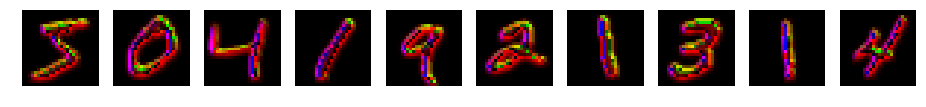

In [20]:
# We can see that each filter seems different features in the images
# ie horizontal / diagonal / vertical segments
plt.figure(figsize=(16,8))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(im[i], interpolation='nearest')
    plt.axis('off')

### Try Clustering

In [67]:
X_first_4 = X_val[y_val < 4][:1000]
y_first_4 = y_val[y_val < 4][:1000]

In [70]:
input_var = T.fmatrix()

out_layer = l_conv
out_var = lasagne.layers.get_output(out_layer, deterministic=True, inputs=input_var)
out_fn = theano.function([input_var], out_var)

In [71]:
all_out = out_fn(X_first_4)

In [72]:
flattened_out = all_out.reshape(all_out.shape[0],-1)

In [23]:
import sklearn.metrics

In [73]:
flattened_out.shape

(1000, 2352)

In [74]:
pairwise_distances = sklearn.metrics.pairwise.pairwise_distances(flattened_out)

In [75]:
sorted_dist = np.sort(pairwise_distances, axis=1)

In [76]:
k_neighbours = 5
dist_to_k_th_neighbour = sorted_dist[:,k_neighbours+1] #1 to ignore distance to self

In [77]:
dist_to_k_th_neighbour_sorted = np.sort(dist_to_k_th_neighbour)

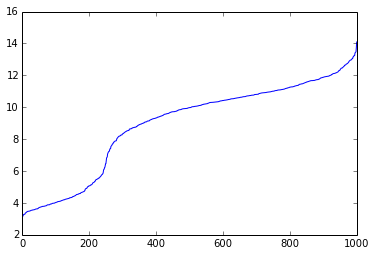

In [78]:
plt.plot(range(len(dist_to_k_th_neighbour_sorted)), dist_to_k_th_neighbour_sorted)

In [114]:
%%time
from sklearn.cluster import DBSCAN
clusterer = DBSCAN(eps=9, min_samples=5)
fitted_labels = clusterer.fit_predict(flattened_out)

CPU times: user 6.69 s, sys: 4 ms, total: 6.7 s
Wall time: 6.69 s


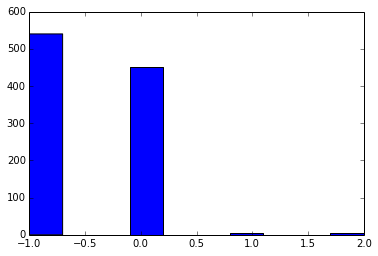

In [115]:
plt.hist(fitted_labels)
None

In [105]:
np.unique(fitted_labels)

array([-1.,  0.,  1.,  2.])

In [122]:
from braindecode.veganlasagne.layers import get_input_shape
from numpy.random import RandomState
from braindecode.analysis.cluster import optimize_to_move_to_cluster

In [138]:
rand_in_var, update_fn = optimize_to_move_to_cluster(out_layer,n_cluster_samples=k_neighbours)

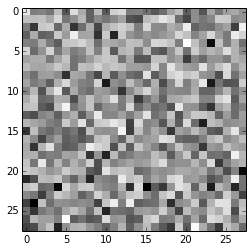

In [139]:
from copy import deepcopy
orig_val = deepcopy(rand_in_var.get_value())
plt.imshow(orig_val.reshape(28,28), interpolation='nearest', cmap=cm.Greys)

3.52229619026
0.0055050435476
0.00422381609678
0.00379522377625
0.00368546950631
0.00362440384924
0.00358467781916
0.0035457983613
0.00350264040753
0.00346016185358


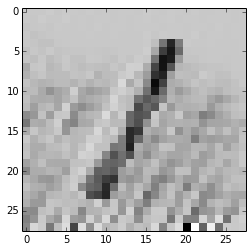

In [166]:
rand_in_var, update_fn = optimize_to_move_to_cluster(out_layer,n_cluster_samples=k_neighbours)
cluster_activations = all_out[fitted_labels == 0]
for i_epoch in range(1000):
    cost = update_fn(cluster_activations)
    if i_epoch % 100 == 0:
        print cost
plt.imshow(rand_in_var.get_value().reshape(28,28), interpolation='nearest', cmap=cm.Greys)

3.5007584095
0.00889925006777
0.00830311607569
0.00786565896124
0.00777446199208
0.00769696151838
0.0075340308249
0.00752338999882
0.00767458975315
0.00758221605793


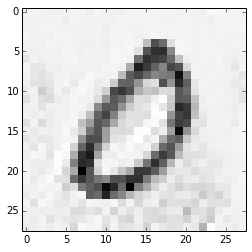

In [172]:
rand_in_var, update_fn = optimize_to_move_to_cluster(out_layer,n_cluster_samples=k_neighbours,
                                                    learning_rate=0.3)
cluster_activations = all_out[y_first_4 == 0]
for i_epoch in range(1000):
    cost = update_fn(cluster_activations)
    if i_epoch % 100 == 0:
        print cost
plt.imshow(rand_in_var.get_value().reshape(28,28), interpolation='nearest', cmap=cm.Greys)
None

3.56233143806
0.00393679738045
0.00374796940014
0.0036729821004
0.00362389092334
0.00356906233355
0.00348122604191
0.00346776540391
0.00351077015512
0.00338252866641


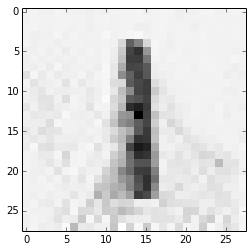

In [173]:
rand_in_var, update_fn = optimize_to_move_to_cluster(out_layer,n_cluster_samples=k_neighbours,
                                                    learning_rate=0.3)
cluster_activations = all_out[y_first_4 == 1]
for i_epoch in range(1000):
    cost = update_fn(cluster_activations)
    if i_epoch % 100 == 0:
        print cost
plt.imshow(rand_in_var.get_value().reshape(28,28), interpolation='nearest', cmap=cm.Greys)
None

3.50185537338
0.00895832292736
0.00842970144004
0.00806428864598
0.00795775093138
0.00788822304457
0.00756447855383
0.00747500965372
0.00756855681539
0.0076447497122


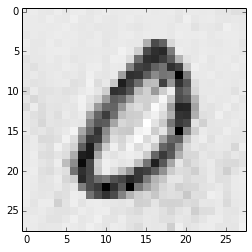

In [175]:
mean_squared = lambda x: T.mean(T.square(x)) * 0.001
rand_in_var, update_fn = optimize_to_move_to_cluster(out_layer,n_cluster_samples=k_neighbours,
                                                    learning_rate=0.3,
                                                    input_cost=mean_squared)
cluster_activations = all_out[y_first_4 == 0]
for i_epoch in range(1000):
    cost = update_fn(cluster_activations)
    if i_epoch % 100 == 0:
        print cost
plt.imshow(rand_in_var.get_value().reshape(28,28), interpolation='nearest', cmap=cm.Greys)
None

3.50185537338
0.00895832292736
0.00842970144004
0.00806428864598
0.00795774720609
0.00790626369417
0.00757942628115
0.0074642682448
0.00756353000179
0.00761948339641


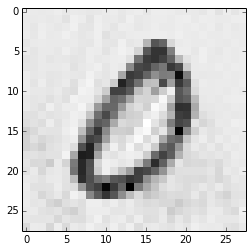

In [177]:
mean_squared = lambda x: T.mean(T.square(x)) * 0.001
rand_in_var, update_fn = optimize_to_move_to_cluster(out_layer,n_cluster_samples=k_neighbours,
                                                    learning_rate=0.3,
                                                    input_cost=mean_squared)
cluster_activations = all_out[y_first_4 == 0]
for i_epoch in range(1000):
    cost = update_fn(cluster_activations)
    if i_epoch % 100 == 0:
        print cost
plt.imshow(rand_in_var.get_value().reshape(28,28), interpolation='nearest', cmap=cm.Greys)
None

3.49882888794
0.0153798600659
0.014633637853
0.0141381276771
0.0137028936297
0.0136744119227
0.0136534254998
0.0135344266891
0.0135008459911
0.0135594392195


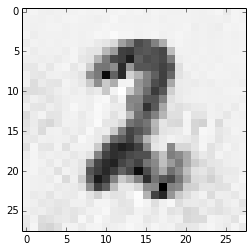

In [178]:
mean_squared = lambda x: T.mean(T.square(x)) * 0.001
rand_in_var, update_fn = optimize_to_move_to_cluster(out_layer,n_cluster_samples=k_neighbours,
                                                    learning_rate=0.3,
                                                    input_cost=mean_squared)
cluster_activations = all_out[y_first_4 == 2]
for i_epoch in range(1000):
    cost = update_fn(cluster_activations)
    if i_epoch % 100 == 0:
        print cost
plt.imshow(rand_in_var.get_value().reshape(28,28), interpolation='nearest', cmap=cm.Greys)
None

3.50485134125
0.0166840925813
0.0160824749619
0.0157204214483
0.0156630966812
0.0155411558226
0.0155343608931
0.0155158909038
0.0156468432397
0.0156899187714


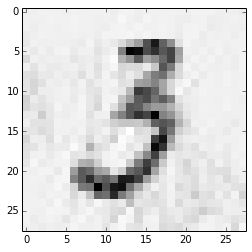

In [179]:
mean_squared = lambda x: T.mean(T.square(x)) * 0.001
rand_in_var, update_fn = optimize_to_move_to_cluster(out_layer,n_cluster_samples=k_neighbours,
                                                    learning_rate=0.3,
                                                    input_cost=mean_squared)
cluster_activations = all_out[y_first_4 == 3]
for i_epoch in range(1000):
    cost = update_fn(cluster_activations)
    if i_epoch % 100 == 0:
        print cost
plt.imshow(rand_in_var.get_value().reshape(28,28), interpolation='nearest', cmap=cm.Greys)
None

## Verification of reshape correctness

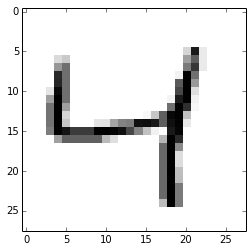

In [130]:
from matplotlib import cm
im = X_train[2].reshape(28,28)
plt.imshow(im, interpolation='nearest',cmap=cm.Greys)